In [1]:
dir_data = '../data'

dir_ckpt = [
    '../ckpt/1668270620',  # GoodLuckk
    '../ckpt/1668265483',  # GoodLuck ()
    '../ckpt/1668432245',  # SE
]

path_ckpt = list(map(lambda x: f'{x}/last_ckpt.bin', dir_ckpt))

seed = 0
ids = range(0, 21)

features = [
    'temperature', 'humidity', 'dew_point', 'wind_dir', 'wind_spd',
    'uv_idx', 'visibility', 'ceiling', 'cloudiness', 'precip_prob',
    'precip_1h', 'forecast', 'capacity', 'hour', 'year', 'month', 'day'
]

hidden_dim = 10

In [2]:
import sys
sys.path.append('../')

from suncapturer.utils import seed_all

from suncapturer.losses import CompetitionMetric
from suncapturer.networks import WaveNet
from suncapturer.datasets import SolarDataset

import os
import numpy as np
import pandas as pd
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.preprocessing import MinMaxScaler, minmax_scale


In [3]:
seed_all(seed)

In [4]:
df = pd.read_csv(os.path.join(dir_data, 'forecasts1_16.csv'))
df = df.fillna(0)

start = datetime.strptime('2020-09-30', '%Y-%m-%d')

df['fcst_time'] = df['fcst_time'].str.split(' ').str[0]
df['fcst_time'] = pd.to_datetime(df['fcst_time'])
df['fcst_time'] = (df['fcst_time'] - start).dt.days

valid_start = df['fcst_time'].max() - 17
train_df = df[(df['id'].isin(ids)) & (df['fcst_time'] < valid_start)].copy()
valid_df = df[(df['id'].isin(ids)) & (df['fcst_time'] >= valid_start)].copy()
test_df  = df[(df['id'] == 0) & (df['fcst_time'] >= valid_start) ].copy()

target_columns = df.columns.difference(['id', 'fcst_time', 'time', 'amount', 'relative_amount'])
for col in target_columns:
    scaler = MinMaxScaler()
    scaler.fit(train_df[col].values.reshape(-1, 1))
    
    train_df[col] = scaler.transform(train_df[col].values.reshape(-1, 1))
    valid_df[col] = scaler.transform(valid_df[col].values.reshape(-1, 1))
    test_df[col] = scaler.transform(test_df[col].values.reshape(-1, 1))

valid_dataset = SolarDataset(valid_df, features)
test_dataset = SolarDataset(test_df, features)

In [5]:
models = []
for i in range(len(dir_ckpt)):
    model = WaveNet(len(features), 10)
    ckpt = torch.load(path_ckpt[i])
    model.load_state_dict(ckpt['model_state_dict'])
    models.append(model)

In [6]:
@torch.no_grad()
def evaluate(model, dataset, k=0.0):
    score = []
    model.eval()
    for X, y in dataset:
        X, y = map(lambda x: x.unsqueeze(0), [X, y])
        out = model(X)

        bound = torch.zeros_like(out)
        bound[:, :, 0] = out[:, :, 0] - k * out[:, :, 1]
        bound[:, :, 1] = out[:, :, 0] + k * out[:, :, 1]
        bound = torch.nn.functional.relu(bound)

        loss = list(metric(bound, y).values())
        loss = list(map(lambda x: x.numpy(), loss))
        score.append(loss)
        
    return np.mean(score, axis=0)

In [7]:
# [0, 3, 4]
metric = CompetitionMetric()
scores = []
for i in range(len(dir_ckpt)):
    scores.append(evaluate(models[i], test_dataset, 0.01))

print(np.stack(scores))

with torch.no_grad():    
    bounds_ = []
    scores_ = []
    labels_ = []  
    for X, y in test_dataset:
        X, y = map(lambda x: x.unsqueeze(0), [X, y])
        outs = []
        for i in range(len(dir_ckpt)):
            outs.append(models[i](X))
        out = torch.stack(outs).mean(dim=0)

        bound = torch.zeros_like(out)
        bound[:, :, 0] = out[:, :, 0] - 0.01 * out[:, :, 1]
        bound[:, :, 1] = out[:, :, 0] + 0.01 * out[:, :, 1]
        bound = torch.nn.functional.relu(bound)

        score = list(metric(bound, y).values())
        score = list(map(lambda x: x.numpy(), score))
        scores_.append(score)
        bounds_.append(bound.numpy())
        labels_.append(y.numpy())
        
print(np.mean(scores, axis=0))

start = 6
interval = 9


scores = scores_[start:start+interval]
bounds = bounds_[start:start+interval]
labels = labels_[start:start+interval]

scores = np.stack(scores)
bounds = 473.29 * np.hstack(bounds)[0]
labels = 473.29 * np.hstack(labels)[0]

[[3.2623732e-01 5.9315878e-01 9.8090893e-45 2.9424019e+00]
 [3.6273649e-01 6.4914024e-01 1.2687449e-02 2.9424019e+00]
 [3.3791542e-01 6.1439168e-01 0.0000000e+00 2.9424019e+00]]
[0.3422964  0.6188969  0.00422915 2.942402  ]


/home/dongjin/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
  return F.conv1d(input, weight, bias, self.stride,


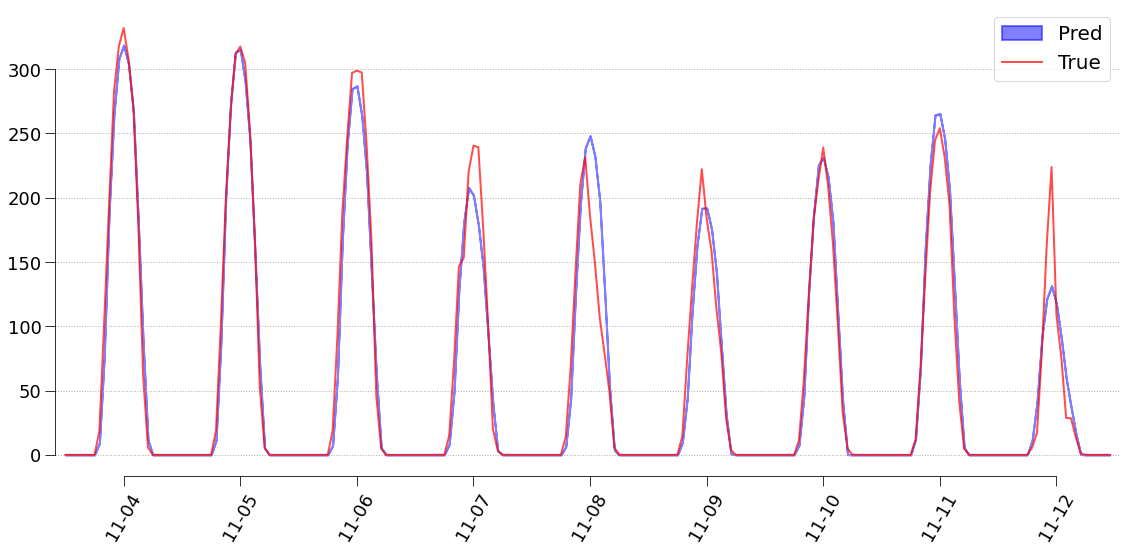

0.21525177


In [15]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Helvectica'
plt.rcParams['font.size'] = 18

x_from = range(len(bounds))[12::24]
x_to = pd.date_range(start='2022-11-4', end='2022-11-12', freq='1d')
x_to = [datetime.strftime(t, '%m-%d') for t in x_to]

fig, ax = plt.subplots(figsize=(16, 8))

ax.fill_between(x=range(len(bounds)), y1=bounds[:, 0], y2=bounds[:, 1], color='b', alpha=0.5, label='Pred', linewidth=2)
ax.plot(range(len(bounds)), labels, 'r', zorder=3, label='True',linewidth=2, alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines.left.set_bounds(0, 300)
ax.spines.bottom.set_bounds(12, 204)
ax.margins(x=0.01)
ax.tick_params(length=10)
plt.xticks(x_from, x_to, rotation=60)
plt.grid(axis='y', zorder=1, linestyle='dotted', linewidth=1)
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()

print(scores[:, 0].mean())

In [17]:
# [0, 3, 4]
metric = CompetitionMetric()
scores = []
for i in range(len(dir_ckpt)):
    scores.append(evaluate(models[i], test_dataset, 0.01))

print(np.stack(scores))

with torch.no_grad():    
    bounds_ = []
    scores_ = []
    labels_ = []  
    for X, y in test_dataset:
        X, y = map(lambda x: x.unsqueeze(0), [X, y])
        outs = []
        for i in range(len(dir_ckpt)):
            outs.append(models[i](X))
        out = torch.stack(outs).mean(dim=0)

        bound = torch.zeros_like(out)
        bound[:, :, 0] = out[:, :, 0] - 0.5 * out[:, :, 1]
        bound[:, :, 1] = out[:, :, 0] + 0.5 * out[:, :, 1]
        bound = torch.nn.functional.relu(bound)

        score = list(metric(bound, y).values())
        score = list(map(lambda x: x.numpy(), score))
        scores_.append(score)
        bounds_.append(bound.numpy())
        labels_.append(y.numpy())
        
print(np.mean(scores, axis=0))

start = 6
interval = 9


scores = scores_[start:start+interval]
bounds = bounds_[start:start+interval]
labels = labels_[start:start+interval]

scores = np.stack(scores)
bounds = 473.29 * np.hstack(bounds)[0]
labels = 473.29 * np.hstack(labels)[0]

[[3.2623732e-01 5.9315878e-01 9.8090893e-45 2.9424019e+00]
 [3.6273649e-01 6.4914024e-01 1.2687449e-02 2.9424019e+00]
 [3.3791542e-01 6.1439168e-01 0.0000000e+00 2.9424019e+00]]
[0.3422964  0.6188969  0.00422915 2.942402  ]


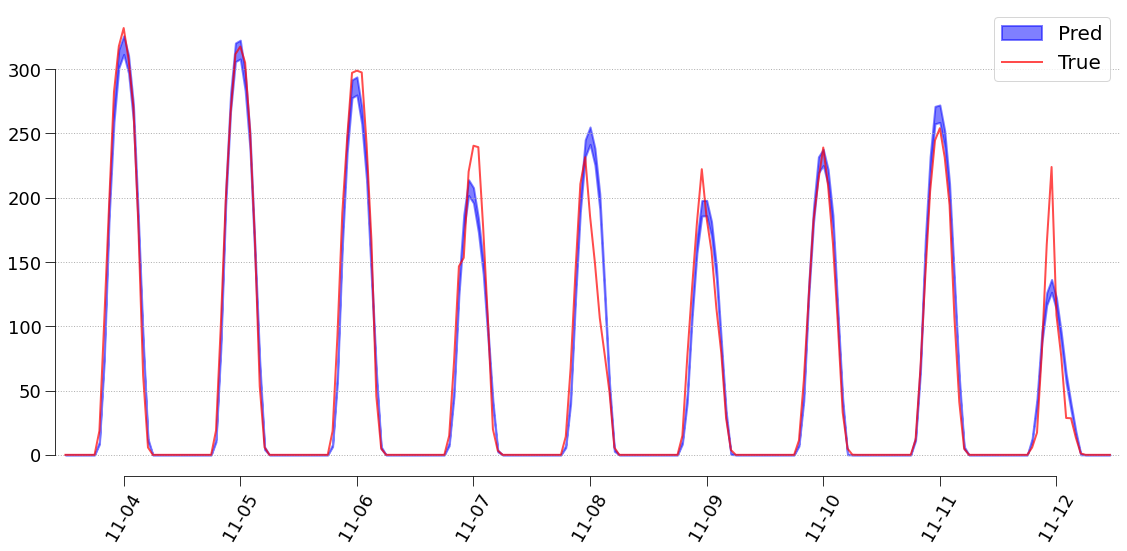

0.3084307


In [18]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Helvectica'
plt.rcParams['font.size'] = 18

x_from = range(len(bounds))[12::24]
x_to = pd.date_range(start='2022-11-4', end='2022-11-12', freq='1d')
x_to = [datetime.strftime(t, '%m-%d') for t in x_to]

fig, ax = plt.subplots(figsize=(16, 8))

ax.fill_between(x=range(len(bounds)), y1=bounds[:, 0], y2=bounds[:, 1], color='b', alpha=0.5, label='Pred', linewidth=2)
ax.plot(range(len(bounds)), labels, 'r', zorder=3, label='True',linewidth=2, alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines.left.set_bounds(0, 300)
ax.spines.bottom.set_bounds(12, 204)
ax.margins(x=0.01)
ax.tick_params(length=10)
plt.xticks(x_from, x_to, rotation=60)
plt.grid(axis='y', zorder=1, linestyle='dotted', linewidth=1)
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()

print(scores[:, 0].mean())